# Classification sample (Bank Marketing Data)

Analyze which items affect the importance of improving sales performance.

- Dataset: Bank Marketing Data Set https://archive.ics.uci.edu/ml/datasets/bank+marketing

- `sklearn.model_selection.train_test_split`
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
  - `strafify`: https://scikit-learn.org/stable/modules/cross_validation.html#stratification


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from typing import Union, List, Dict, Any
import calendar


DF_RAW = pd.read_csv(
    "bank-full.csv",
    sep=';'
)


def expand_to_one_hot_vector(dataframe, column_name: str):
    """Expand the category value to a One-Hot vector."""
    one_hot_vector = pd.get_dummies(
        dataframe[column_name],
        prefix=column_name
    )
    df_dropped = dataframe.drop([column_name], axis=1)
    return pd.concat(
        [
            df_dropped,
            one_hot_vector
        ],
        axis=1
    )


def numerate_binary_labels(
    dataframe,
    column_name: str,
    label_0: Union[str, bool] = 'no',
    label_1: Union[str, bool] = 'yes'
) -> None:
    """Numerate binary labels in a dataframe column.
    """
    if dataframe[column_name].dtypes == np.bool_:
        dataframe[column_name] = dataframe[column_name].astype(np.int_)
        return

    if set(dataframe[column_name].values) == {0, 1}:
        return

    dataframe[column_name] = dataframe[column_name].map({
        label_1: 1,
        label_0: 0,
    })
    return


def models() -> Dict[str, Any]:
    """Classifier models dictionary.
    
    LogisticRegression (solver)
    - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    - https://scikit-learn.org/stable/modules/linear_model.html#solvers
    - In this case, default 'lbfgs' failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
    """
    return {
        'Logistic_Regression': LogisticRegression(
            solver='liblinear',
            random_state=0
        ),
        'Decision_Tree': DecisionTreeClassifier(
            max_depth=3,
            random_state=0
        ),
        'Random_Forest': RandomForestClassifier(
            max_depth=3,
            random_state=0
        ),
        'XGBoost': XGBClassifier(random_state=0)
    }


def extended_confusion_matrix(np_matrix, columns: List[str]):
    """Extend confusion matrix by add labels."""
    n = len(columns)
    predict_result = ['Predicted result'] * n
    actual = ['Actual'] * n
    return pd.DataFrame(
        np_matrix, 
        columns=[predict_result, columns],
        index=[actual, columns]
    )


def distplot_scatter_success_failure(
    target_1,
    target_0,
    bins: int,
    title: str,
    xlabel: str = None,
    fig_size = (5, 3)
) -> None:
    """Show success and failure scatterplot usint distplot.
    FIXME:`distplot` is a deprecated function and will be removed in seaborn v0.14.0, so replace to `histplot`.
    - https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
    """
    plt.figure(figsize=fig_size)
    sns.distplot(
        target_1,
        kde=False,
        norm_hist=True,
        bins=bins,
        color='b',
        label='Success'
    )
    sns.distplot(
        target_0,
        kde=False,
        norm_hist=True,
        bins=bins,
        color='k',
        label='Failure'
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()


def prediction_for_changing_threshold(model, x, threshould: float):
    """Prediction when the threshold value is changed."""
    y_proba = model.predict_proba(x)
    y_proba_result_1 = y_proba[:,1]
    return (y_proba_result_1 > threshould).astype(int)


In [2]:
# Confirm dataset content
display(DF_RAW.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
print(f"shape:{DF_RAW.shape}\n")
print(f"y:\n{DF_RAW['y'].value_counts()}\n")
print(
    f"Sales success rate = {DF_RAW['y'].value_counts()['yes']/len(DF_RAW)}"
)

shape:(45211, 17)

y:
no     39922
yes     5289
Name: y, dtype: int64

Sales success rate = 0.11698480458295547


In [4]:
print(DF_RAW.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [5]:
# Numeric multivalued labels. (Expand one category to multiple categories)
df = DF_RAW.copy()

df = expand_to_one_hot_vector(df, 'job')
df = expand_to_one_hot_vector(df, 'marital')
df = expand_to_one_hot_vector(df, 'education')
df = expand_to_one_hot_vector(df, 'contact')
df = expand_to_one_hot_vector(df, 'poutcome')

display(df.head())

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,...,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,...,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,...,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,...,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,...,0,0,1,0,0,1,0,0,0,1


In [6]:
# Numerate binary labels.
numerate_binary_labels(df, 'default')
numerate_binary_labels(df, 'housing')
numerate_binary_labels(df, 'loan')
numerate_binary_labels(df, 'y')

display(df.head())

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,may,261,1,-1,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,...,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,...,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,...,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,...,0,0,1,0,0,1,0,0,0,1


In [7]:
# Replace month names(jan, feb, ...) with numbers 1~12.
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [8]:
month_names = [
    month[0:3].lower() for month in calendar.month_name
][1:]

df['month'] = df['month'].map(
    {month_names[i]: (i + 1) for i in range(0, len(month_names))}
)

display(df)

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,...,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,...,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,...,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,11,977,3,-1,...,0,1,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,11,456,2,-1,...,0,0,0,1,0,0,0,0,0,1
45208,72,0,5715,0,0,17,11,1127,5,184,...,1,0,0,1,0,0,0,0,1,0
45209,57,0,668,0,0,17,11,508,4,-1,...,1,0,0,0,1,0,0,0,0,1


In [9]:
# Sprit dataset & prepare test and train data.
X = df.drop('y', axis=1)
y = df['y'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=0,
    stratify=y
)

In [10]:
# Select the best model using the cross-validation method.
stratified_kfold = StratifiedKFold(n_splits=3)

for key, model in models().items():
    scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=stratified_kfold,
        scoring='roc_auc'
    )
    score = scores.mean()

    print(
        f'mean: {score:.4f}, socores: {scores} ({key})'
    )

mean: 0.8889, socores: [0.88857016 0.88777958 0.89038261] (Logistic_Regression)
mean: 0.7866, socores: [0.77479806 0.79768143 0.78744801] (Decision_Tree)
mean: 0.8803, socores: [0.88973969 0.86686215 0.88417146] (Random_Forest)
mean: 0.9256, socores: [0.92379313 0.92327844 0.92979319] (XGBoost)


In [11]:
# Using model XGBoost.
algorithm = models()['XGBoost']

# Lerning
algorithm.fit(X_train, y_train)

# Prediction
y_pred = algorithm.predict(X_test)

# Evaluation (confusion matrix)
df_matrix = extended_confusion_matrix(
    confusion_matrix(y_test, y_pred),
    ['fail', 'success']
)

display(df_matrix)

Predicted result        
                           fail success
Actual fail               15401     568
       success             1121     995

In [12]:
# Evaluation (presision, recall, fscore)
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test,
    y_pred,
    average='binary'
)

print(
    f'Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score: {fscore:.4f}'
)

Precision: 0.6366, Recall: 0.4702, F-Score: 0.5409


/tmp/ipykernel_6785/1901253104.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_6785/1901253104.py:123: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


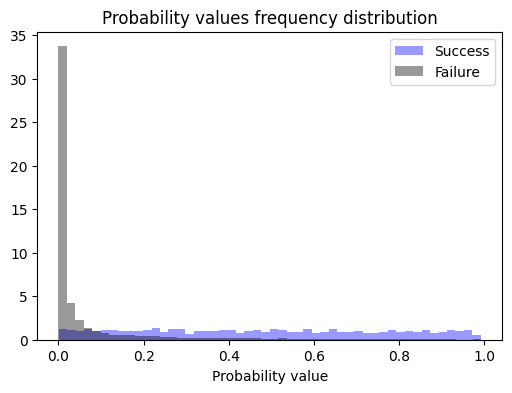

In [13]:
# Show probability values frequency distribution.
y_proba_0 = algorithm.predict_proba(X_test)[:,1]
y_0 = y_proba_0[y_test==0]
y_1 = y_proba_0[y_test==1]

distplot_scatter_success_failure(
    y_1,
    y_0,
    50,
    title='Probability values frequency distribution',
    xlabel='Probability value',
    fig_size = (6, 4)
)

In [14]:
# The optimal threshold is determined by looking at the change in the evaluation when the threshold is changed.
threshoulds = np.arange(0.5, 0, -0.05)

for threshould in threshoulds:
    y_predict = prediction_for_changing_threshold(
        algorithm,
        X_test,
        threshould
    )
    pred_sum = y_predict.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test,
        y_predict,
        average='binary'
    )
    print(
        f'Threshould: {threshould:.4f}, Prediction Sum: {pred_sum:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score: {fscore:.4f}'
    )

Threshould: 0.5000, Prediction Sum: 1563.0000, Precision: 0.6366, Recall: 0.4702, F-Score: 0.5409
Threshould: 0.4500, Prediction Sum: 1787.0000, Precision: 0.6206, Recall: 0.5241, F-Score: 0.5683
Threshould: 0.4000, Prediction Sum: 2024.0000, Precision: 0.6008, Recall: 0.5747, F-Score: 0.5874
Threshould: 0.3500, Prediction Sum: 2264.0000, Precision: 0.5835, Recall: 0.6243, F-Score: 0.6032
Threshould: 0.3000, Prediction Sum: 2516.0000, Precision: 0.5636, Recall: 0.6701, F-Score: 0.6123
Threshould: 0.2500, Prediction Sum: 2820.0000, Precision: 0.5465, Recall: 0.7283, F-Score: 0.6244
Threshould: 0.2000, Prediction Sum: 3231.0000, Precision: 0.5144, Recall: 0.7854, F-Score: 0.6217
Threshould: 0.1500, Prediction Sum: 3701.0000, Precision: 0.4769, Recall: 0.8341, F-Score: 0.6068
Threshould: 0.1000, Prediction Sum: 4351.0000, Precision: 0.4328, Recall: 0.8899, F-Score: 0.5823
Threshould: 0.0500, Prediction Sum: 5505.0000, Precision: 0.3629, Recall: 0.9442, F-Score: 0.5243


- The __threshold 0.2500__ with an optimal __F-score 0.6244__ is the best we can do.

In [15]:
y_pred_final = prediction_for_changing_threshold(
    algorithm,
    X_test,
    0.25
)

# Evaluation (confusion matrix)
df_matrix_final = extended_confusion_matrix(
    confusion_matrix(y_test, y_pred_final),
    ['fail', 'success']
)
display(df_matrix_final)

# Evaluation (presision, recall, fscore)
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test,
    y_pred_final,
    average='binary'
)
print(
    f'Precision: {precision:.4f}, Recall: {recall:.4f}, F-Score: {fscore:.4f}'
)

Predicted result        
                           fail success
Actual fail               14690    1279
       success              575    1541

Precision: 0.5465, Recall: 0.7283, F-Score: 0.6244


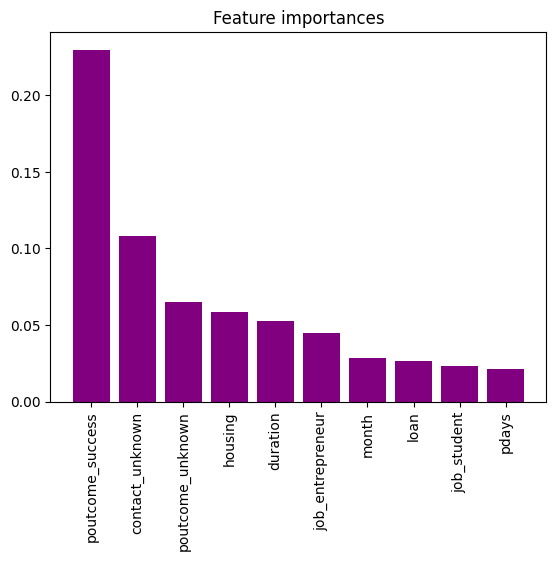

In [16]:
# Feature importances analysis.
SAMPLE_SIZE: int = 10

importances = algorithm.feature_importances_
importance_series = pd.Series(
    importances,
    index=X.columns
)
importance_series_desc = importance_series.sort_values(
    ascending=False
)[:SAMPLE_SIZE]

plt.bar(
    range(SAMPLE_SIZE),
    importance_series_desc,
    color='purple',
    align='center'
)
plt.xticks(
    range(SAMPLE_SIZE),
    importance_series_desc.index,
    rotation=90
)
plt.title('Feature importances')
plt.show()

/tmp/ipykernel_6785/1901253104.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_6785/1901253104.py:123: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


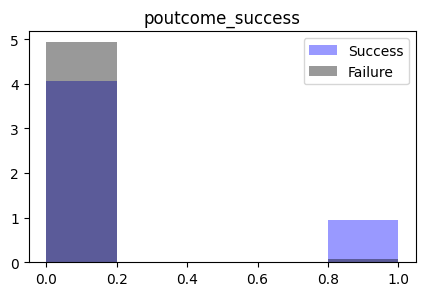

In [17]:
column = 'poutcome_success'

distplot_scatter_success_failure(
    X_test[y_test==1][column],
    X_test[y_test==0][column],
    5,
    title=column
)

The graph on the right side confirms that the influence was in the positive direction, which means that we can draw the conclusion that customers who were successful in the previous promotion are influenced in the positive direction.

/tmp/ipykernel_6785/1901253104.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_6785/1901253104.py:123: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


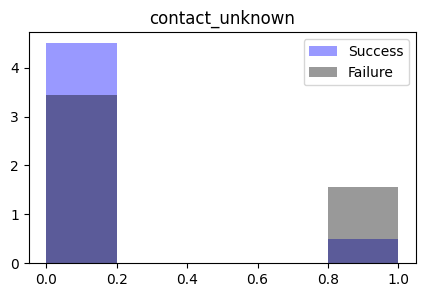

In [18]:
column = 'contact_unknown'

distplot_scatter_success_failure(
    X_test[y_test==1][column],
    X_test[y_test==0][column],
    5,
    title=column
)

/tmp/ipykernel_6785/1901253104.py:115: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_6785/1901253104.py:123: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


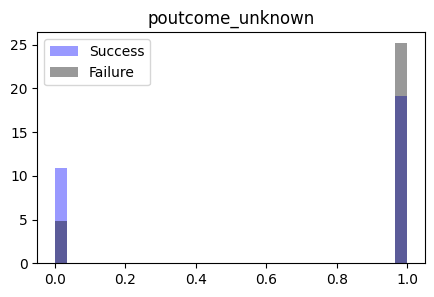

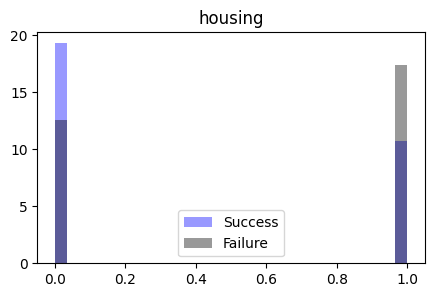

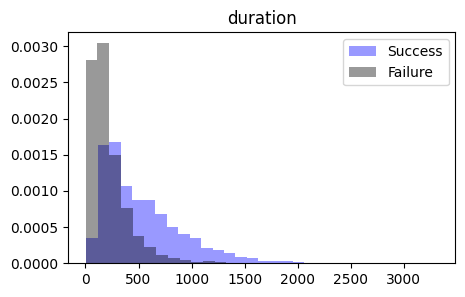

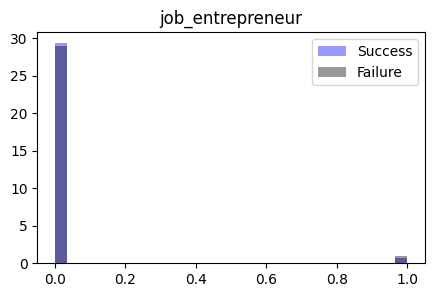

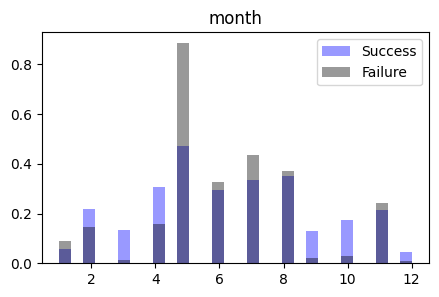

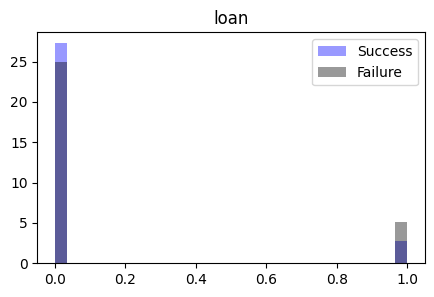

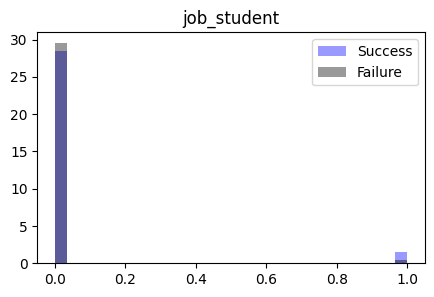

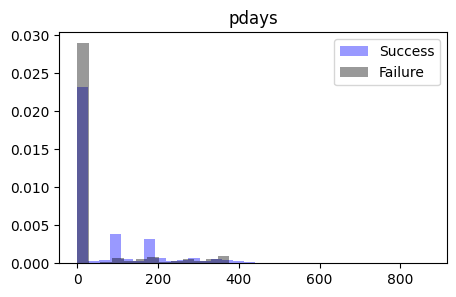

In [19]:
len(importance_series_desc.index)

for col in importance_series_desc.index[2:]:
    distplot_scatter_success_failure(
        X_test[y_test==1][col],
        X_test[y_test==0][col],
        30,
        title=col
    )